In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.signal import savgol_filter

### 1: Data extraction
Extract RhoA median levels across cell lines for KO and DLC1 cells from pickle file (Lucien Hinderling).

In [2]:
# Import dataset and visualise relevant columns
data_dir = os.path.join("../Data")
path_to_df = os.path.join(data_dir, "max_focal_adhesions.pkl")
df = pd.read_pickle(path_to_df)
df.columns

Index(['label', 'x', 'y', 'pax', 'rhoa', 'label_cell_mean', 'dist', 'pax_max',
       'rhoa_max', 'label_cell', 'dist_max', 'exp', 'frame', 'cell_type',
       'type', 'fov', 'pax_cell', 'rhoa_cell', 'roi_id', 'rhoa_norm',
       'rhoa_ratio_norm', 'pax_norm', 'pax_ratio_norm'],
      dtype='object')

In [3]:
# Extract the median RhoA activity across all frames for WT and KO cells at membrane and FA
median_NONFA_KO_rhoa_per_frame = df[((df['type']=='NON-FA') & 
                                     (df['cell_type']=='KO') & 
                                     (df['dist'] > 0))].groupby('frame')['rhoa_ratio_norm'].median()
median_NONFA_rhoa_per_frame = df[((df['type']=='NON-FA') & 
                                  (df['cell_type']=='WT') & 
                                  (df['dist'] > 0))].groupby('frame')['rhoa_ratio_norm'].median()
median_FA_KO_rhoa_per_frame = df[((df['type']=='FA') & 
                                  (df['cell_type']=='KO') & 
                                  (df['dist'] > 0))].groupby('frame')['rhoa_ratio_norm'].median()
median_FA_rhoa_per_frame = df[((df['type']=='FA') & 
                               (df['cell_type']=='WT') &
                               (df['dist'] > 0))].groupby('frame')['rhoa_ratio_norm'].median()

### 2: Plotting

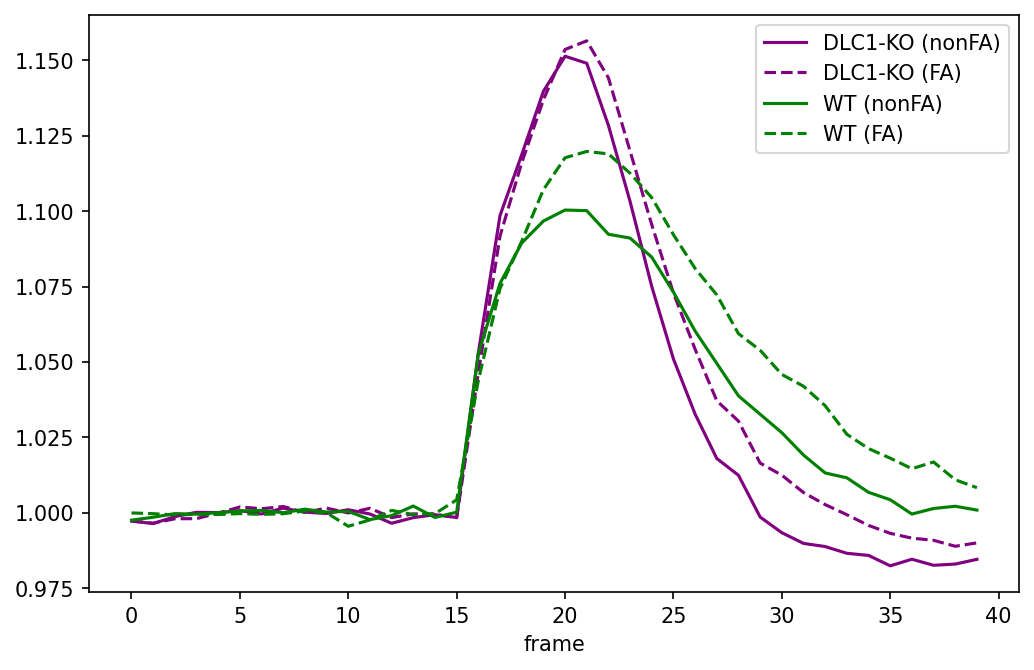

In [34]:
# Visualise the data
plt.figure(dpi = 150, figsize = (8,5))
dist = 0

median_NONFA_KO_rhoa_per_frame.plot(c = 'purple', label = "DLC1-KO (nonFA)")
median_FA_KO_rhoa_per_frame.plot(c = 'purple',linestyle = 'dashed', label = "DLC1-KO (FA)")

median_NONFA_rhoa_per_frame.plot(c = 'green', label = "WT (nonFA)")
median_FA_rhoa_per_frame.plot(c = 'green',linestyle = 'dashed', label = "WT (FA)")
plt.legend()

### 3: Empirical rates calculation
Compute empirical de-/activation rates using the raw data. The 10-90% time window of the activation, resp. deactivation period is taken to approximate the observed rate of activation, resp. deactivation.

In [31]:
# Define 10-90% of activation time window 150-200s
act_t10 = 15.5
act_t90 = 19.5

# Define 10-90% of deactivation time window 200-400s
deact_t10 = 22
deact_t90 = 38

timeframe = np.arange(40)
act_window = (timeframe >= act_t10) & (timeframe <= act_t90)
deact_window = (timeframe >= deact_t10) & (timeframe <= deact_t90)

In [32]:
# Smooth the signal
smooth_NONFA_KO = savgol_filter(median_NONFA_KO_rhoa_per_frame, window_length=9, polyorder=3)
smooth_FA_KO = savgol_filter(median_FA_KO_rhoa_per_frame, window_length=9, polyorder=3)
smooth_NONFA = savgol_filter(median_NONFA_rhoa_per_frame, window_length=9, polyorder=3)
smooth_FA = savgol_filter(median_FA_rhoa_per_frame, window_length=9, polyorder=3)

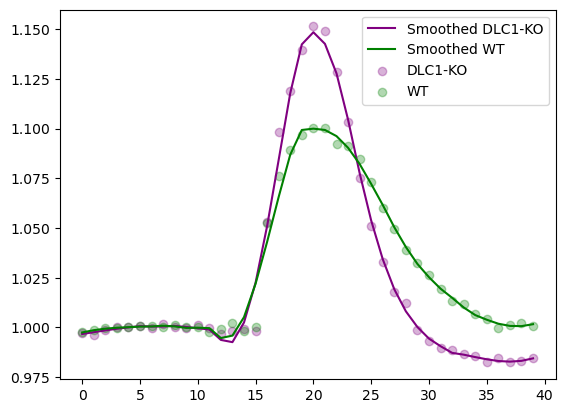

In [44]:
# Plot the smoothed version
plt.plot(smooth_NONFA_KO, label = "Smoothed DLC1-KO", c = 'purple')
plt.plot(smooth_NONFA, label="Smoothed WT", c = 'green')
plt.scatter(timeframe, median_NONFA_KO_rhoa_per_frame, label="DLC1-KO", alpha=0.3, c = 'purple')
plt.scatter(timeframe, median_NONFA_rhoa_per_frame, label="WT", alpha=0.3, c = 'green')
plt.legend()
plt.show()

In [49]:
# Derive the observed dynamics over the time window
dsmooth_NONFA_KO_dt = np.gradient(smooth_NONFA_KO, timeframe)
dsmooth_NONFA_dt = np.gradient(smooth_NONFA, timeframe)
dsmooth_FA_KO_dt = np.gradient(smooth_FA_KO, timeframe)
dsmooth_FA_dt = np.gradient(smooth_FA, timeframe)

# Compute the mean observed rates
act_rates = {
    "NONFA_KO": np.mean(dsmooth_NONFA_KO_dt[act_window]),
    "NONFA": np.mean(dsmooth_NONFA_dt[act_window]),
    "FA_KO":np.mean(dsmooth_FA_KO_dt[act_window]),
    "FA": np.mean(dsmooth_FA_dt[act_window])
}

deact_rates = {
    "NONFA_KO": np.mean(dsmooth_NONFA_KO_dt[deact_window]),
    "NONFA": np.mean(dsmooth_NONFA_dt[deact_window]),
    "FA_KO":np.mean(dsmooth_FA_KO_dt[deact_window]),
    "FA": np.mean(dsmooth_FA_dt[deact_window])
}

In [55]:
print("Activation Rates:")
for condition, rate in act_rates.items():
    print(f"  {condition:<15}: {rate:.5f}")
print()
    
print("Dectivation Rates:")
for condition, rate in deact_rates.items():
    print(f"  {condition:<15}: {-rate:.5f}")

Activation Rates:
  NONFA_KO       : 0.02716
  NONFA          : 0.01678
  FA_KO          : 0.02818
  FA             : 0.02051

Dectivation Rates:
  NONFA_KO       : 0.00890
  NONFA          : 0.00568
  FA_KO          : 0.00918
  FA             : 0.00642


### 4: Julia-compatible Export
Export to txt file for compatibility reasons with Julia.

In [ ]:
# Export to txt files to import with Julia
median_NONFA_KO_rhoa_per_frame.to_csv("../Data/median_rhoa_NONFA_KO_dynamics.txt",
                                      index=False, header=False)
median_NONFA_rhoa_per_frame.to_csv("../Data/median_rhoa_NONFA_dynamics.txt",
                                      index=False, header=False)
median_FA_KO_rhoa_per_frame.to_csv("../Data/median_rhoa_FA_KO_dynamics.txt",
                                      index=False, header=False)
median_FA_rhoa_per_frame.to_csv("../Data/median_rhoa_FA_dynamics.txt",
                                      index=False, header=False)

In [ ]:
# Export to npy files to import with numpy (all variables in one file)
t = np.arange(0, 40)
np.savez(
    "../Data/median_rhoa_dynamics.npz",
    t = t,
    rhoa_FA = np.array(median_FA_rhoa_per_frame),
    rhoa_FA_KO = np.array(median_FA_KO_rhoa_per_frame),
    rhoa_NONFA = np.array(median_NONFA_rhoa_per_frame),
    rhoa_NONFA_KO = np.array(median_NONFA_KO_rhoa_per_frame)
)